# **Rezbin AI Model v2.0 Development**

We are fine-tuning a VGG-16 model for a multi-class image classification of the TrashNet dataset.

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

Opening our TrashNet dataset via `datasets` from `torchvision`

In [2]:
from pathlib import Path

# opening dataset
dataset_path = Path('../dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

Splitting our dataset by 80% training, and 20% testing

In [3]:
from torch.utils.data import random_split
from torchvision.transforms import v2

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)
    
# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

Plotting our dataset to get a glance of our dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

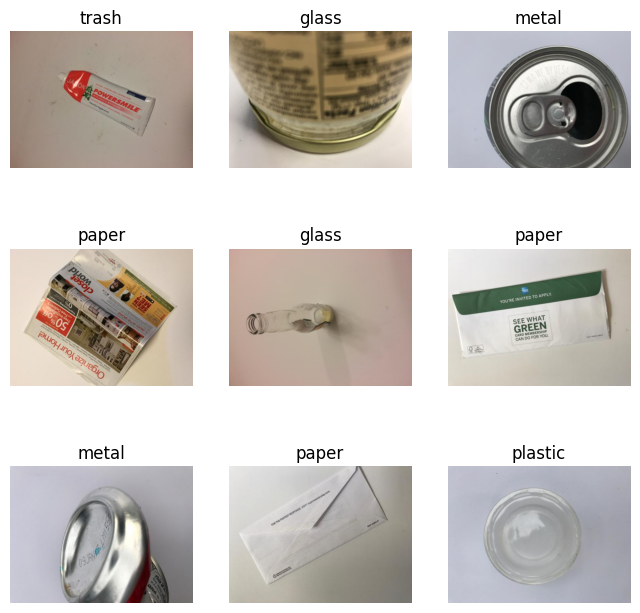

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

Let's define our basic preprocessing transformation pipeline, and plot it to see what it looks like. 

In [6]:
# defining transformation pipeline
transform = v2.Compose([
    # augmentation steps from paper
    v2.RandomAffine(
        degrees=5,
        translate=(0.2, 0.2),
        fill=0                     
    ),
    v2.RandomHorizontalFlip(),
    
    # Transform to image
    v2.Resize((256,256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [7]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


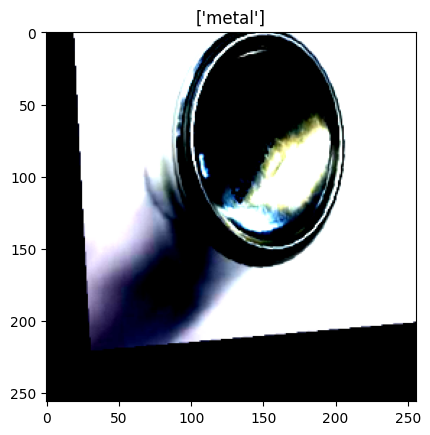

In [8]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0)) # permute cause image is already transformed by preprocessing pipeline
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [9]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze feature layers (we're only training the classifier)
for param in vgg16.features.parameters():
    param.requires_grad = False

c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#Modifying VGG-16's classifier to match our CURRENT dataset
idx_labels = full_dataset.class_to_idx
num_classes = len(idx_labels)
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

In [11]:
# Define hyperparameters in this cell
import torch.nn as nn
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

In [ ]:
# Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

print(next(vgg16.parameters()).device)


vgg16.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Train our model in the cell below

In [13]:
from tqdm import tqdm  # for progress bar

num_epochs = 50  # you can change this later

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

100%|██████████| 32/32 [04:05<00:00,  7.66s/it]


Epoch [1/50], Loss: 0.9672, Accuracy: 63.88%


100%|██████████| 32/32 [03:52<00:00,  7.27s/it]


Epoch [2/50], Loss: 0.5516, Accuracy: 78.92%


100%|██████████| 32/32 [04:00<00:00,  7.52s/it]


Epoch [3/50], Loss: 0.4537, Accuracy: 83.57%


100%|██████████| 32/32 [03:52<00:00,  7.25s/it]


Epoch [4/50], Loss: 0.3896, Accuracy: 86.05%


100%|██████████| 32/32 [03:51<00:00,  7.24s/it]


Epoch [5/50], Loss: 0.3389, Accuracy: 88.03%


 41%|████      | 13/32 [01:44<02:33,  8.06s/it]


KeyboardInterrupt: 

Evaluate on how good is the accuracy of our model.

In [ ]:
vgg16.eval()  # Switch to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 79.84%


In [ ]:
import os

# Define save directory and filename
save_dir = '../models/'
save_path = os.path.join(save_dir, '01_vgg16_finetuned.pth')

# Create directory
os.makedirs(save_dir, exist_ok=True)

# Save the model's state_dict
torch.save(vgg16.state_dict(), save_path)

print(f"Model saved successfully to {save_path}")

Model saved successfully to ../models/01_vgg16_finetuned.pth
